<a href="https://colab.research.google.com/github/iamfady/potato-disease-classification_CNN/blob/main/potato_disease_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village**


## First, let's import the required libraries.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization , Resizing , Rescaling , RandomFlip , RandomRotation
from keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## Collect all variables in one place for easy modification


In [3]:
BATCH_SIZE = 32


IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

IMAGE_CHANNELS=3
EPOCHS=50

## Import Data Via Tensorflow Pipeline


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Data/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    print(len(labels_batch.numpy()))

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]
32


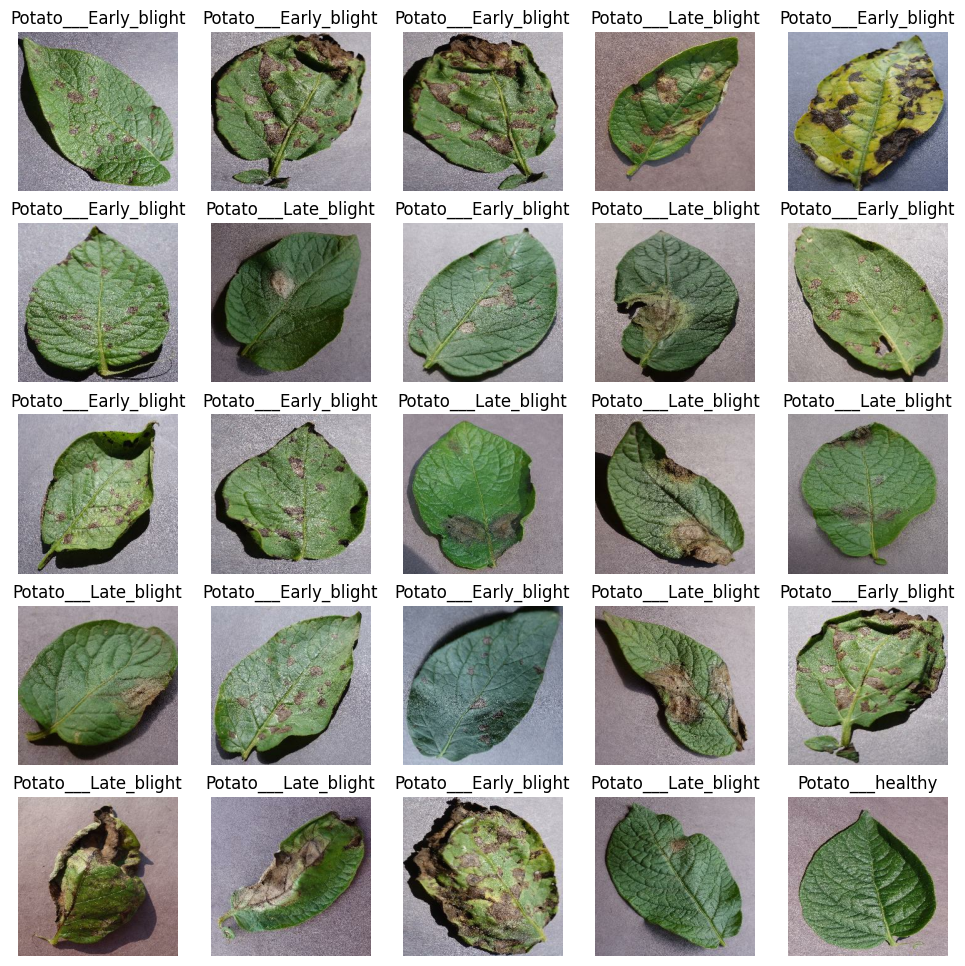

In [8]:
plt.figure(figsize=(12, 12))

for image_batch, labels_batch in dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


## Let's divide the data by a percentage


In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    # Train Data
    train_ds = ds.take(train_size)
    # Validation Data
    val_ds = ds.skip(train_size).take(val_size)
    # Test Data
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
print(f"Train Data: {len(train_ds)}")
print(f"Validation Data: {len(val_ds)}")
print(f"Test Data: {len(test_ds)}")


Train Data: 54
Validation Data: 6
Test Data: 8



## Cache, Shuffle, and Prefetch the Data


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Resizing and Normalization



In [13]:
resize_and_rescale = Sequential([
  Resizing(IMAGE_WIDTH, IMAGE_HEIGHT),
  Rescaling(1./255),
])

## Data Augmentation


In [14]:
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

In [15]:
# Applying Data Augmentation to Train Dataset

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



## Model Architecture


In [16]:
input_shape = (BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
n_classes = 3

In [17]:
model = Sequential([
    resize_and_rescale,

    Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    Conv2D(64,  kernel_size = (3,3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64,  kernel_size = (3,3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax'),
])


In [18]:
model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [20]:
#Early Stopping

early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [21]:
#Compiling the Model

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    #callbacks=[early_stop]
)

Epoch 1/50
54/54 [==============================] - 27s 495ms/step - loss: 0.0734 - accuracy: 0.9722 - val_loss: 0.1461 - val_accuracy: 0.9427
Epoch 2/50
54/54 [==============================] - 27s 493ms/step - loss: 0.0549 - accuracy: 0.9803 - val_loss: 0.1062 - val_accuracy: 0.9635
Epoch 3/50
54/54 [==============================] - 27s 497ms/step - loss: 0.0424 - accuracy: 0.9855 - val_loss: 0.1285 - val_accuracy: 0.9583
Epoch 4/50
54/54 [==============================] - 27s 490ms/step - loss: 0.0621 - accuracy: 0.9786 - val_loss: 0.2459 - val_accuracy: 0.9167
Epoch 5/50
54/54 [==============================] - 27s 490ms/step - loss: 0.0649 - accuracy: 0.9803 - val_loss: 0.2126 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 27s 492ms/step - loss: 0.0594 - accuracy: 0.9786 - val_loss: 0.1537 - val_accuracy: 0.9427
Epoch 7/50
54/54 [==============================] - 27s 491ms/step - loss: 0.0261 - accuracy: 0.9942 - val_loss: 0.3065 - val_accuracy: 0.9375

In [33]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 107ms/step - loss: 0.0992 - accuracy: 0.9805


## Plotting the Accuracy and Loss Curves


In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

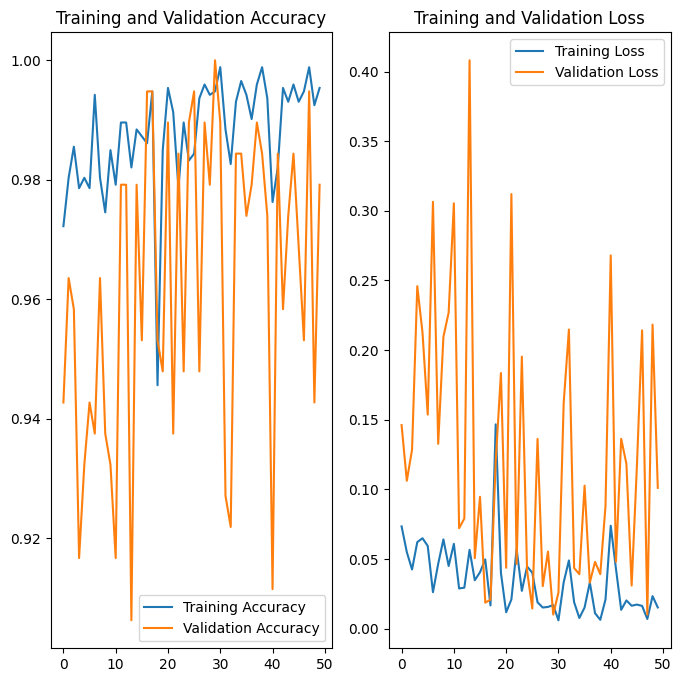

In [35]:
EPOCHS = len(history.history['loss'])

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## prediction on images

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


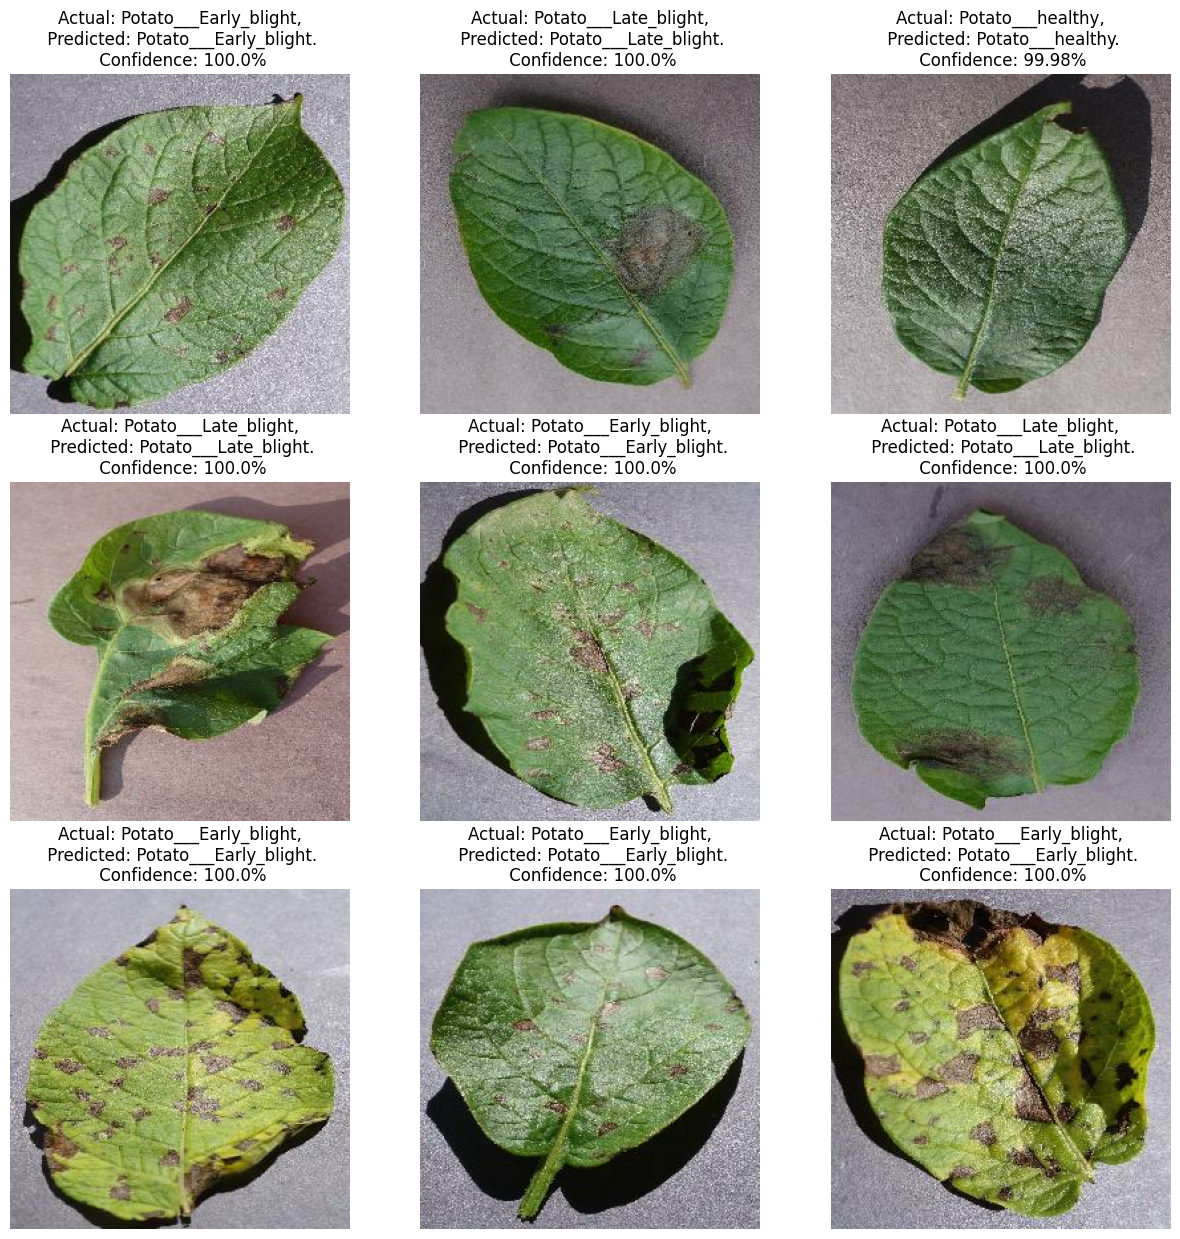

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

## Dynamic Saving the Model


In [38]:
import os

if not os.path.exists("/content/drive/MyDrive/Data/models"):
    os.makedirs("/content/drive/MyDrive/Data/models")

In [39]:
def get_latest_model_version(model_dir):
    versions = []
    for filename in os.listdir(model_dir):
        if filename.endswith('.h5'):  # Check if it's a model file
            try:
                version = int(filename[:-3])  # Extract version number (remove '.h5')
                versions.append(version)
            except ValueError:
                pass  # Ignore files that don't follow the naming convention
    return max(versions, default=0)  # Return 0 if no model files found

model_dir = "/content/drive/MyDrive/Data/models"
model_version = get_latest_model_version(model_dir) + 1
model.save(f"/content/drive/MyDrive/Data/models/{model_version}.h5")
print("Done")

Done
